# PS reconstruction, non-Gaussian beam, t scan study

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir = os.path.join('data', 'non_gaussian_beam', 't_scan')
p0c = 43.36e6 # reference momentum in eV/c
gt_beam = create_beam(
    base_yaml = os.path.join(yaml_dir, 'base.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 100_000,
    save_as = os.path.join(save_dir, 'non_gaussian_beam.pt')
)

data = gt_beam.data.clone()
gt_beam.data = data * 0.5

ground truth distribution saved at data/non_gaussian_beam/t_scan/non_gaussian_beam.pt


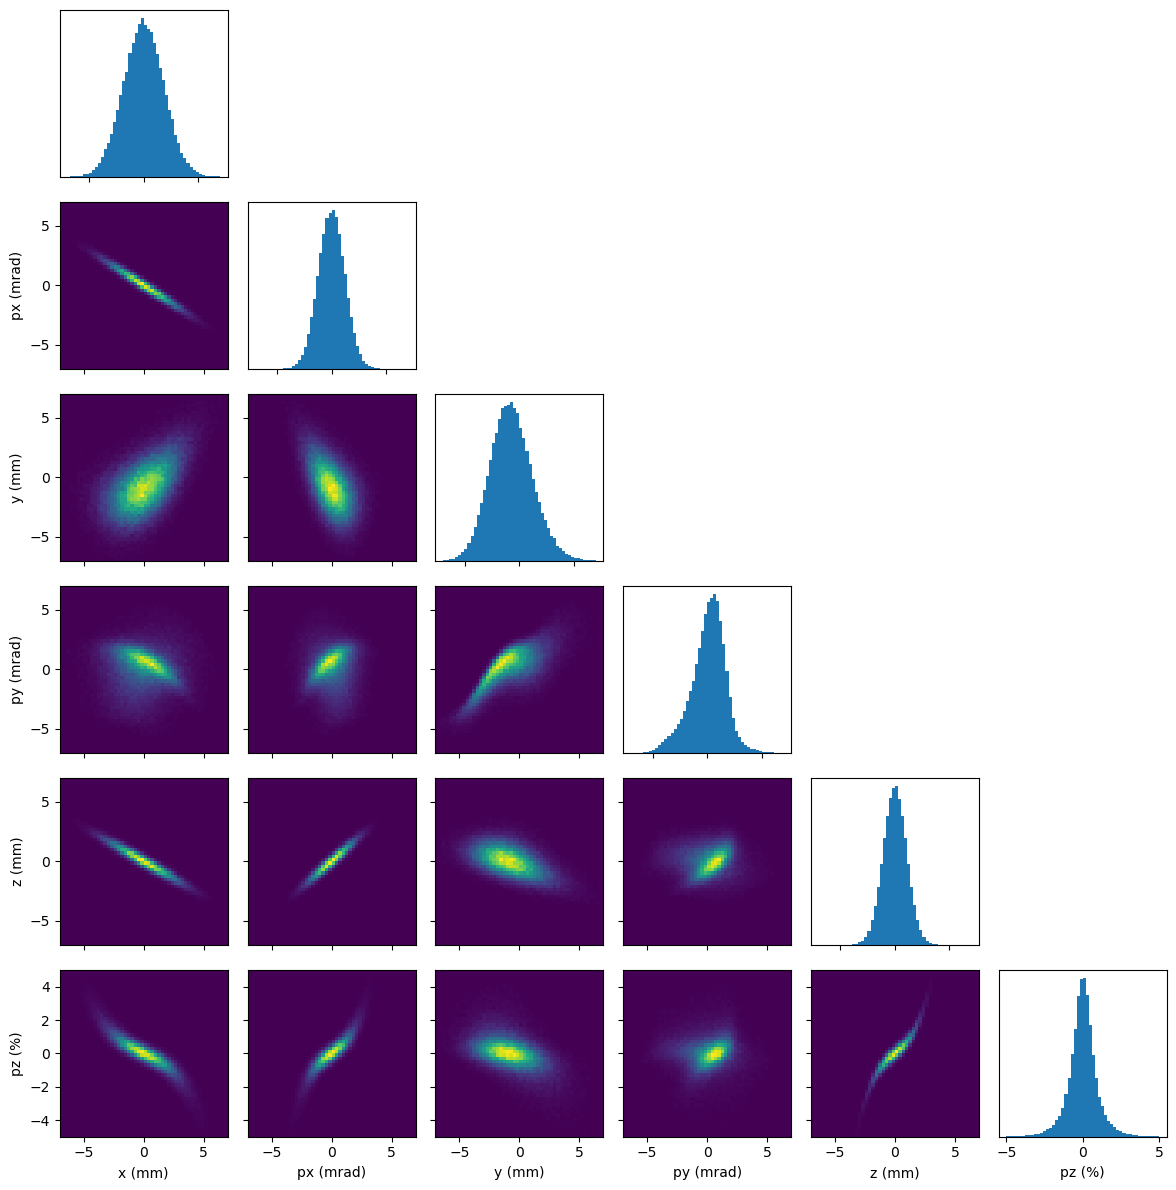

In [3]:
#plot gt beam
lims = np.array([[-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-5e-2, 5e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 =     8.75034
k2 =  -24.402993
k3 =   25.628154

# k1 =     6.10308
# k2 =  -24.441689
# k3 =   25.971829

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-25, 25, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## 'T' scan training data

In [9]:
# generate and save train and test datasets
train_dset_t_scan = run_t_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, 't_scan.dset')
    )

print(train_dset_t_scan.params.shape)
print(train_dset_t_scan.images.shape)

torch.Size([8, 3, 1])
tensor([[-1.0000e+01,  0.0000e+00,  2.2200e-16],
        [-5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 1.0000e+01,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  9.5634e-01],
        [ 0.0000e+00,  5.0000e+06,  2.2200e-16],
        [ 0.0000e+00,  5.0000e+06,  9.5634e-01]])
dataset saved as 'data/non_gaussian_beam/t_scan/t_scan.dset'
torch.Size([8, 3, 1])
torch.Size([8, 1, 200, 200])


In [10]:
%%time

# training
pred_beam_t_scan_100_000, model = train_3d_scan(
    train_dset_t_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 6_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    lambda_=1e14,
    save_dir = save_dir,
    distribution_dump_frequency=500,
    distribution_dump_n_particles=1_000_000,
    )

Using device: cuda:0


/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1694463969407/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4.6434e+09, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(7.0144e+08, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(4.9037e+08, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(4.6073e+08, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(4.8393e+08, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(4.7556e+08, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(4.2396e+08, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(4.0812e+08, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(4.1551e+08, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(4.2080e+08, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(3.8446e+08, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(3.9155e+08, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(4.1863e+08, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(3.8218e+08, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(3.7114e+08, device='cuda:0', grad_fn=<MulBackward0>)
1500 tensor(3.8330e+08, device='cuda:

In [11]:
# make predictions of the beam phase space
model.beam.set_base_beam(1_000_000, p0c=torch.tensor(p0c))
predicted_beam = model.beam.forward().detach_clone()
model.beam.set_base_beam(1_000, p0c=torch.tensor(p0c))


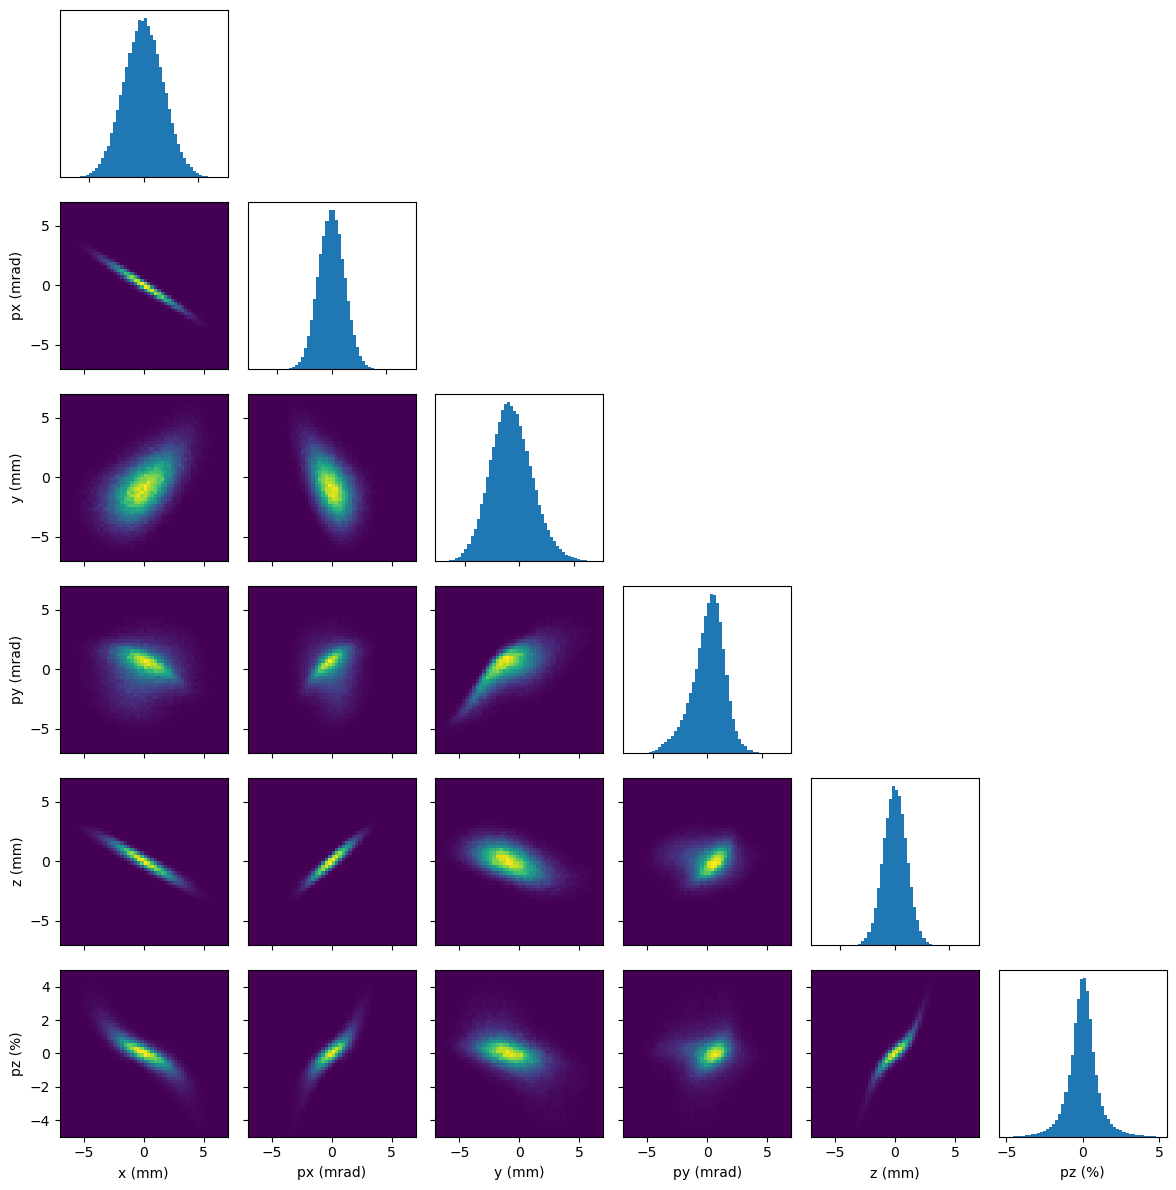

In [12]:
# reconstructed beam projections:
fig, ax = plot_projections(
    pred_beam_t_scan_100_000.numpy_particles(),
    custom_lims = lims
)
plt.show()

In [13]:
torch.cuda.empty_cache()

In [14]:
torch.save(predicted_beam,
           os.path.join(save_dir, 'pred_beam_t_scan_1_000_000.pt'))

(<Figure size 3600x3600 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (mrad)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (mrad)'>]], dtype=object))

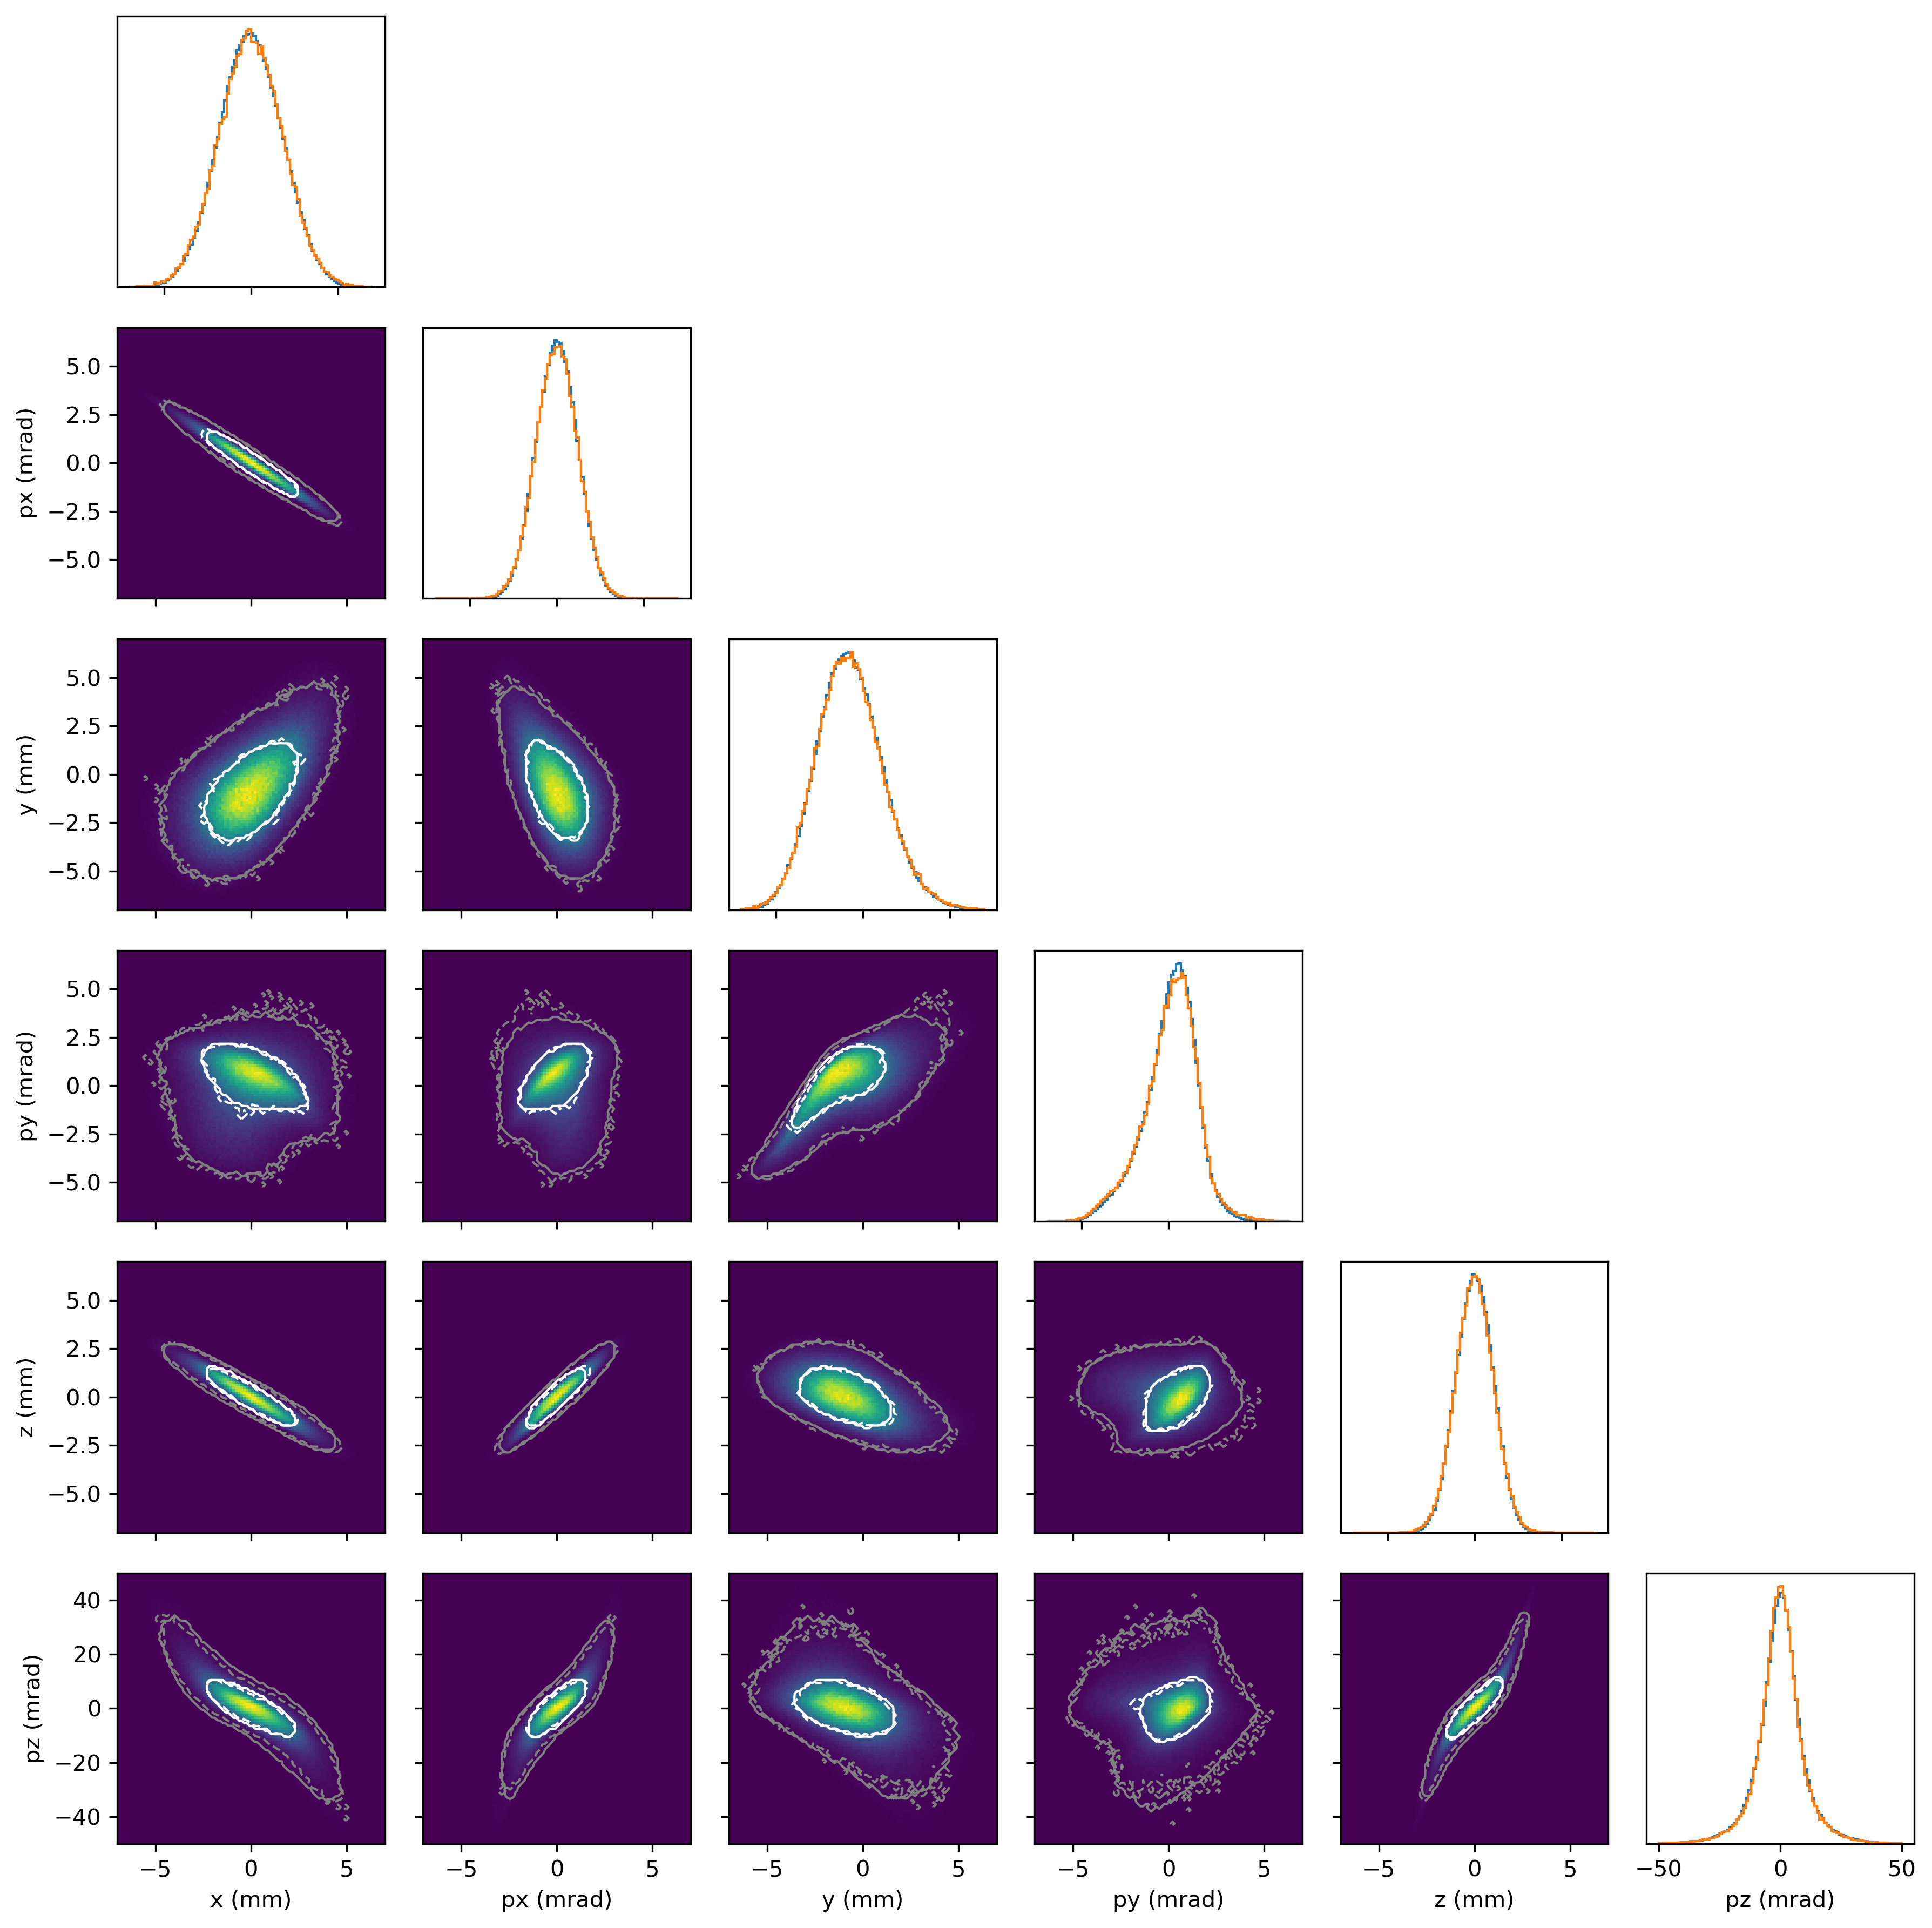

In [16]:
import torch
from stats import plot_projections_with_contours
import os
plot_projections_with_contours(
    torch.load(os.path.join(save_dir, 'pred_beam_t_scan_1_000_000.pt')),
    gt_beam,
    bins=100,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing_r=0.5,
    contour_smoothing_gt=0.5,
)

(<Figure size 3600x3600 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (mrad)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (mrad)'>]], dtype=object))

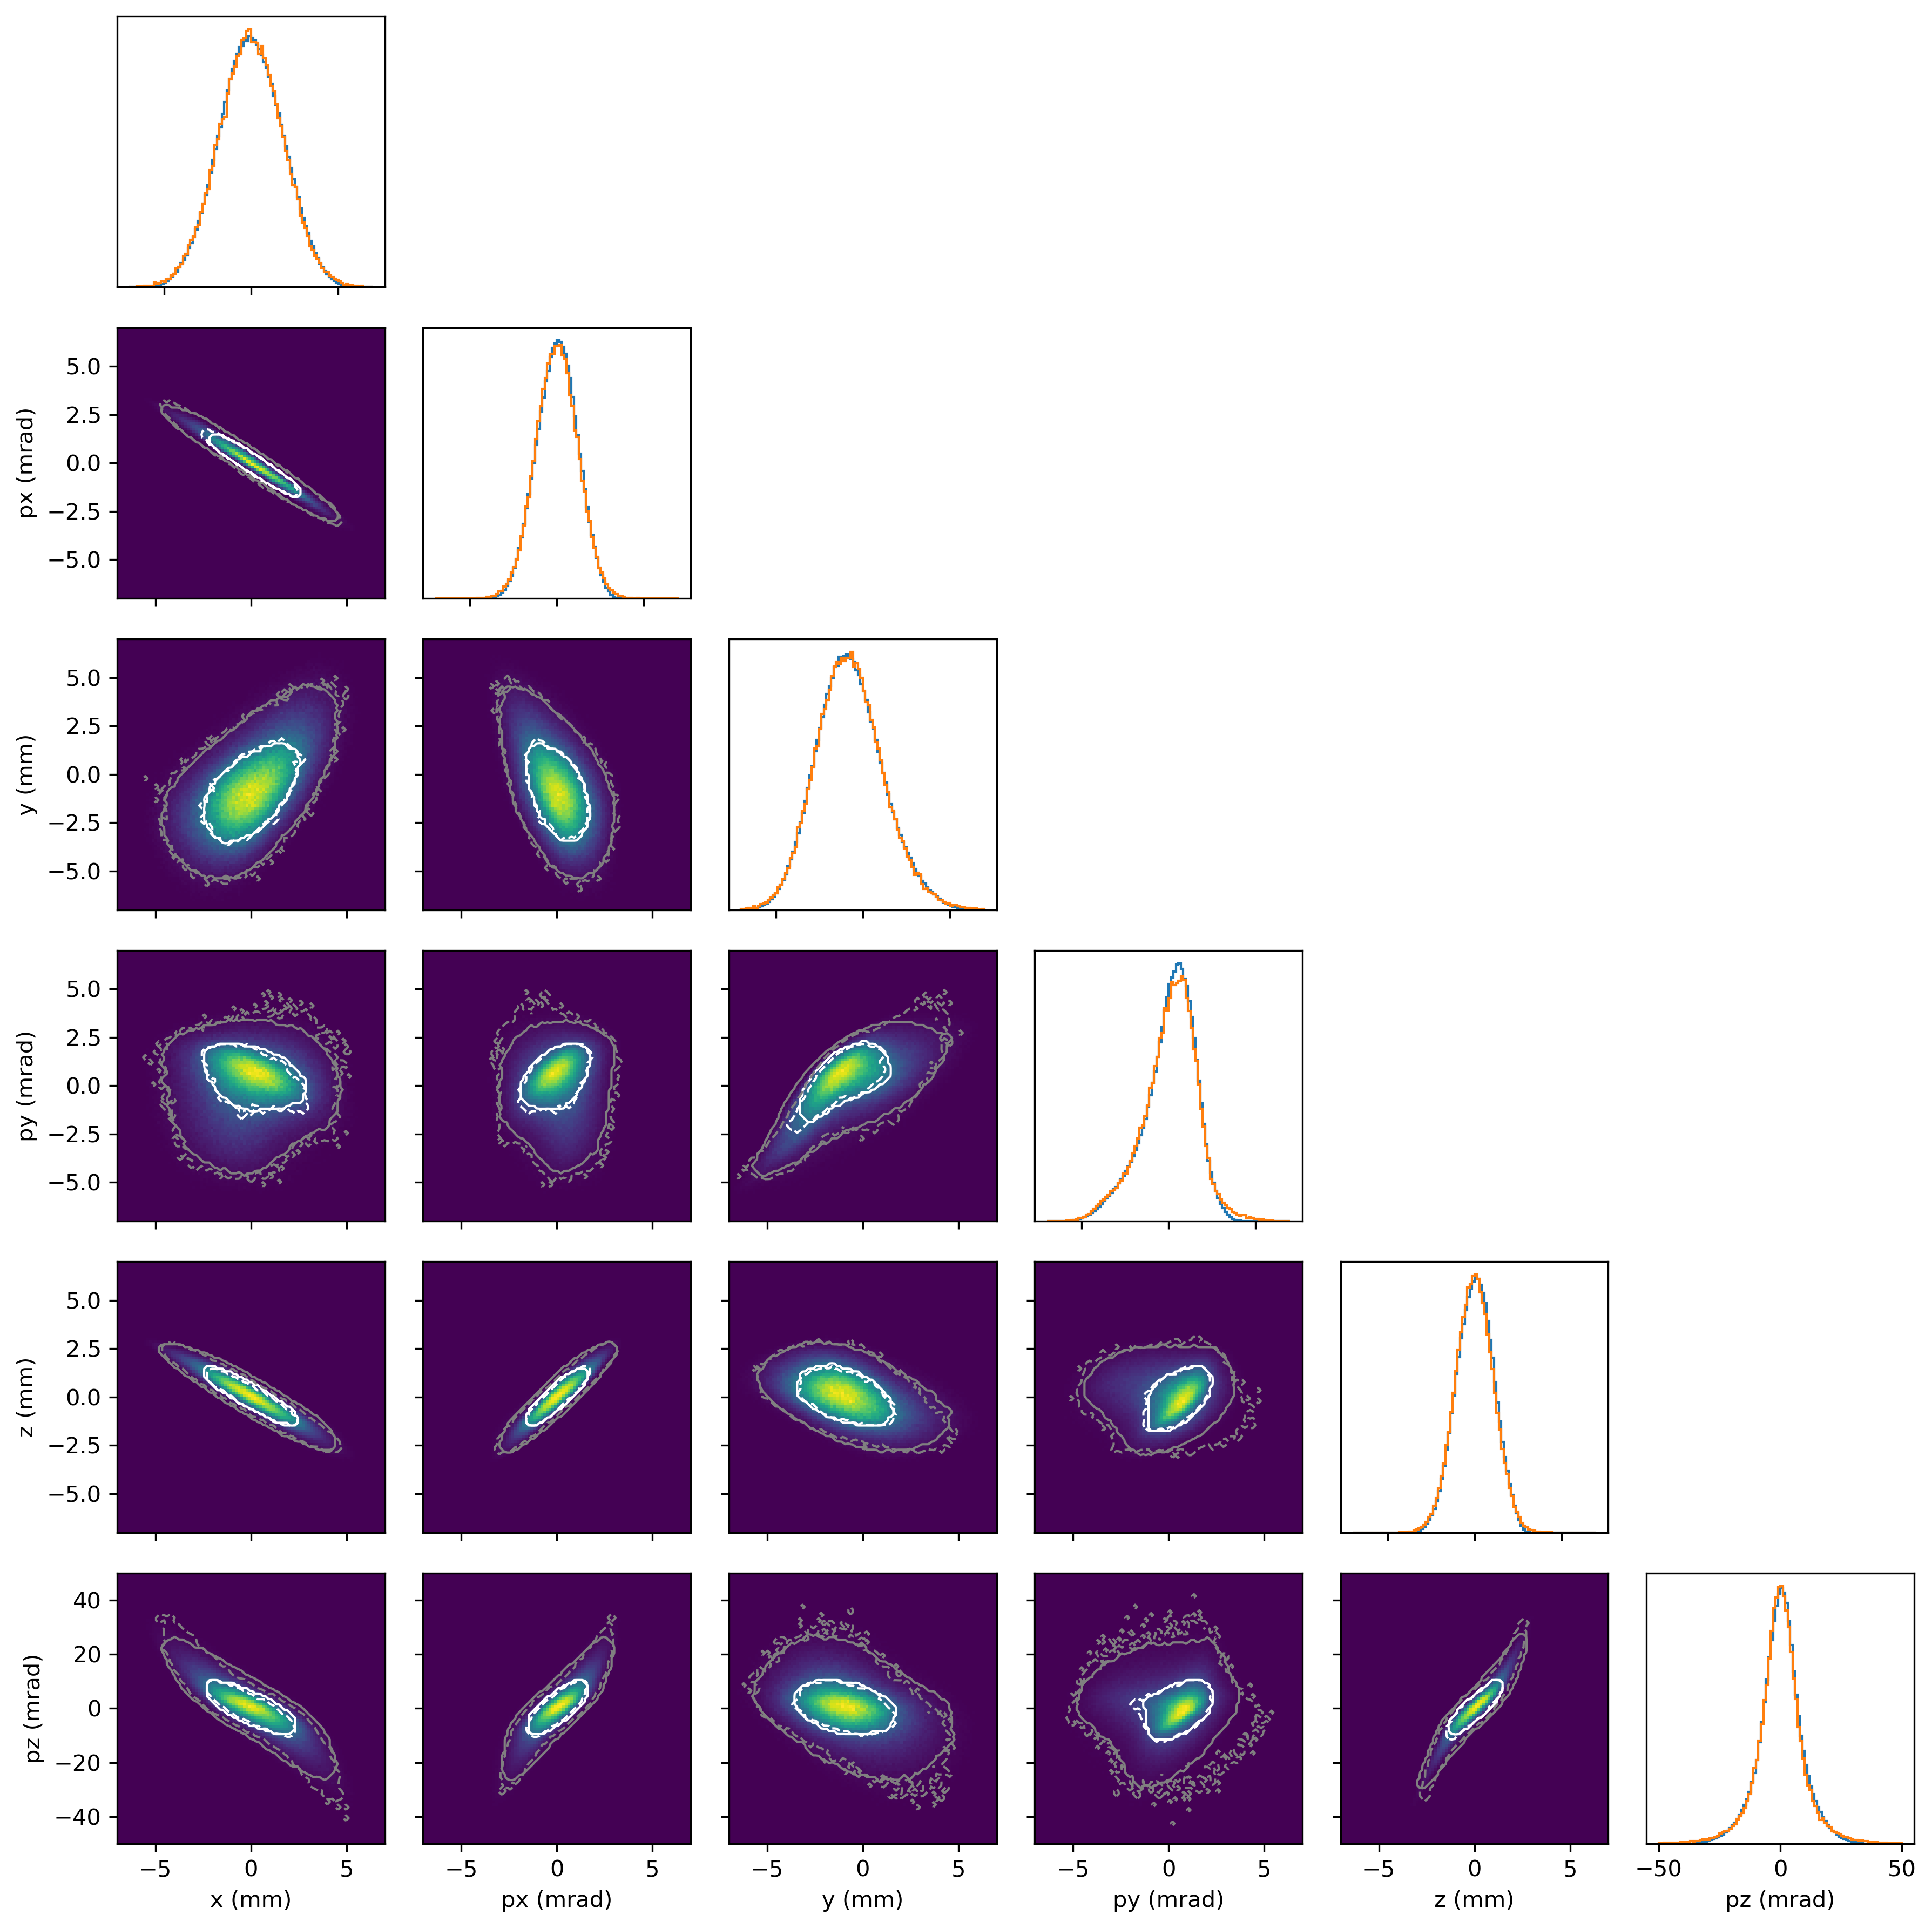

In [17]:
plot_projections_with_contours(
    torch.load(os.path.join(save_dir, 'dist_1000.pt')),
    gt_beam,
    bins=100,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing_r=0.5,
    contour_smoothing_gt=0.5,
)

(<Figure size 3600x3600 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (mrad)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (mrad)'>]], dtype=object))

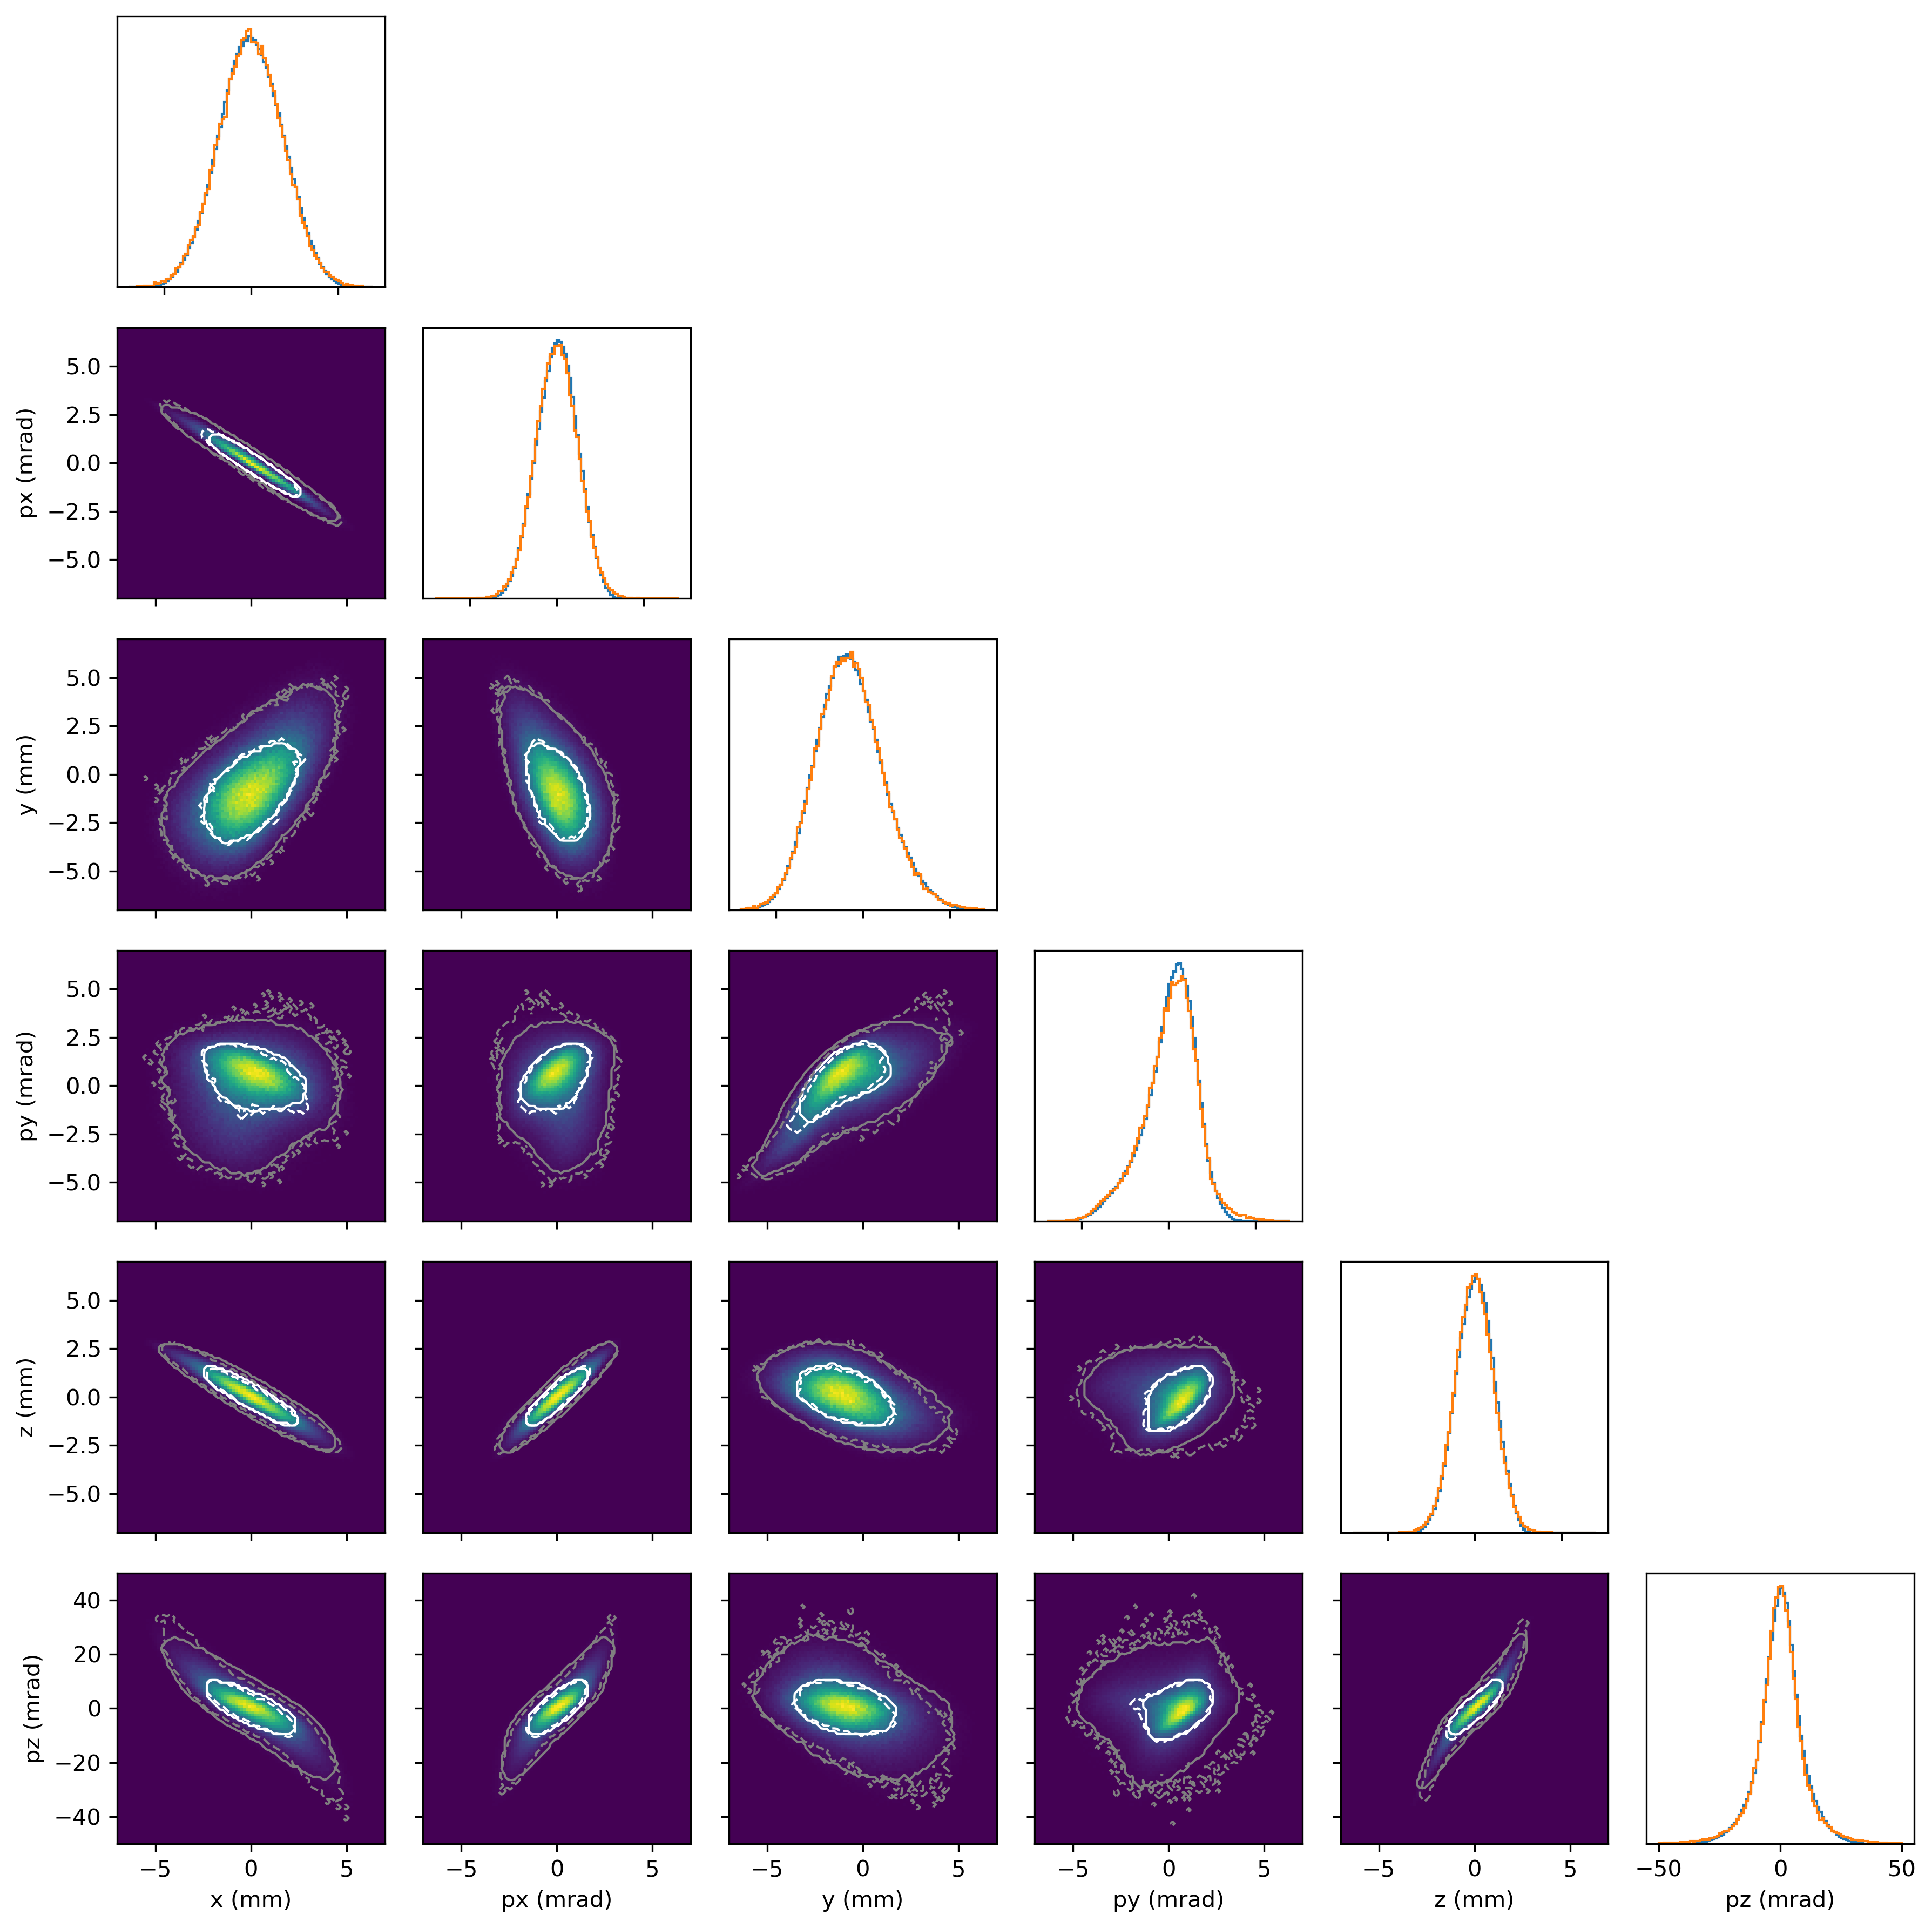

In [21]:
plot_projections_with_contours(
    torch.load(os.path.join(save_dir, 'dist_500.pt')),
    gt_beam,
    bins=100,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing_r=0.5,
    contour_smoothing_gt=0.5,
)